# Maps for Genna

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Rectangle
from cartopy import crs, feature, config
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader
from cmocean import cm

import LambertConformalTicks as lct

%matplotlib inline
plt.rcParams['font.size'] = 14

In [3]:
# Load ETOPO1 as netCDF
topo = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/bathymetry/ETOPO1_Bed_g_gmt4.grd')

In [4]:
xls = pd.ExcelFile('/home/bmoorema/Desktop/LS_eNd_compilation.xlsx')

### Labrador Sea

In [5]:
# Approximate lon/lat shifts to make labels fit
labelshift = [
    ( 0.4,  0.10), # 1
    ( 0.5,  0.10), # 2
    ( 0.4,  0.20), # 3
    (-0.2,  0.30), # 4
    ( 0.5, -0.50), # 5
    ( 0.0,  0.50), # 6
    (-0.5, -1.10), # 7
    (-1.2, -0.90), # 8
    (-1.5, -0.50), # 9
    (-1.0, -1.10), # 10
    (-1.0, -1.10), # 11
    ( 0.4, -0.50), # 12
    (-2.3, -0.40), # 13
    (-2.3, -0.15), # 14
    ( 0.4, -0.30), # 15
    (-1.5,  0.50), # 16
    (-0.0,  0.50), # 17 (right on top of 16)
    (-1.5, -1.00), # 18
    ( 0.2, -0.80), # 19
    (-1.1,  0.30), # 20
    ( 0.4,  0.10), # 21
    (-0.3, -0.95), # 22
    ( 0.4, -0.80), # 23
    ( 0.4, -0.50), # 24
    ( 0.2,  0.30), # 25
    (-1.1, -1.00), # 26
    ( 0.4, -0.20), # 27
    ( 0.4,  0.10), # 28
]

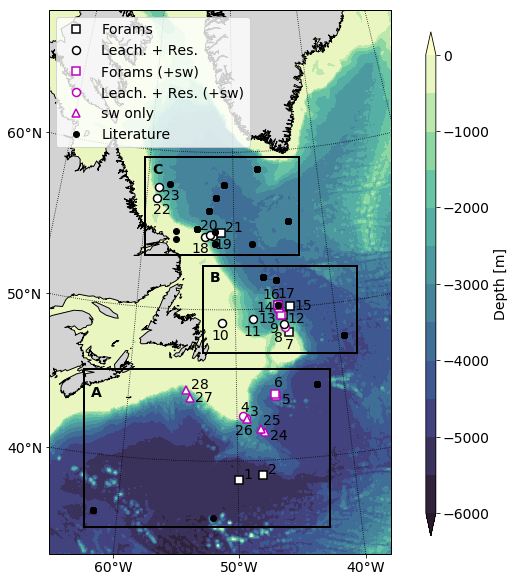

In [6]:
# Define plotting boundaries
xbound, ybound = [-65, -38], [33, 68] # Sets the projection extent
xlim, ylim = [-80, -10], [30, 80]     # Sets the gridline and bathymetry extent (needs to be larger because of conic)

# Make projection and coastlines
fig, ax = plt.subplots(figsize=(7, 10), subplot_kw={'projection': crs.LambertConformal(np.mean(xbound), np.mean(ybound))})
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
ax.set_extent(xbound + ybound)
ax.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='lightgray'))
fig.canvas.draw()

# Add bathymetry (interpolate to 0.1 deg to reduce plotting resolution)
topo_labsea = topo.interp(x=np.arange(*xlim, 0.1), y=np.arange(*ylim, 0.1))
lon, lat, depth = [topo_labsea[var].values for var in ['x', 'y', 'z']]
c = ax.contourf(lon, lat, depth, levels=range(-6000, 1, 500), cmap=cm.deep_r, extend='both', transform=crs.PlateCarree())

# Add gridlines, ticks and colorbar
xticks, yticks = [list(range(*l, 10)) for l in [xlim, ylim]]
ax.gridlines(linestyle=":", color='k', xlocs=xticks, ylocs=yticks)
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lct.lambert_xticks(ax, xticks)
lct.lambert_yticks(ax, yticks)
fig.colorbar(c, cax=cax, label='Depth [m]')

# Plot data locations
fields = ['Number', 'Lon', 'Lat', 'Foraminifera', 'Residue', 'Seawater']
stations = {}
for n, lon, lat, foram, res, sw, shift in zip(*[xls.parse(0)[field].values for field in fields], labelshift):
    marker = 's' if foram == 1 else 'o' if res == 1 else '^'
    ec = 'm' if sw == 1 else 'k'
    stations[n], = ax.plot(
        lon, lat, marker, markerfacecolor='w', markeredgecolor=ec,
        markeredgewidth=1.5, markersize=8, transform=crs.PlateCarree(),
    )
    ax.text(lon+shift[0], lat+shift[1], str(n), transform=crs.PlateCarree())
    
# Plot literature locations
for lon, lat in zip(xls.parse(2).pub_lon, xls.parse(2).pub_lat):
    if lat < 60: lit, = ax.plot(lon, lat, 'ko', markerfacecolor='k', transform=crs.PlateCarree())

# Add rectangles
locs = [((0.1, 0.05), 0.72, 0.29), ((0.45, 0.37), 0.45, 0.16), ((0.28, 0.55), 0.45, 0.18)]
for loc, label in zip(locs, ['A', 'B', 'C']):
    ax.add_patch(Rectangle(*loc, color='k', linewidth=2, fill=False, transform=ax.transAxes, zorder=10))
    shift = 0.05 if label is 'A' else 0.03
    ax.text(loc[0][0] + 0.02, loc[0][1] + loc[2] - shift, label, transform=ax.transAxes, fontdict={'weight': 'bold'})

# Add legend
labels = ['Forams', 'Leach. + Res.', 'Forams (+sw)', 'Leach. + Res. (+sw)', 'sw only', 'Literature']
ax.legend([stations[n] for n in [1, 10, 5, 3, 25]] + [lit], labels, loc=2)

plt.show()
#fig.savefig('/home/bmoorema/Desktop/LabSea_map.pdf', bbox_inches='tight')

### Amazon

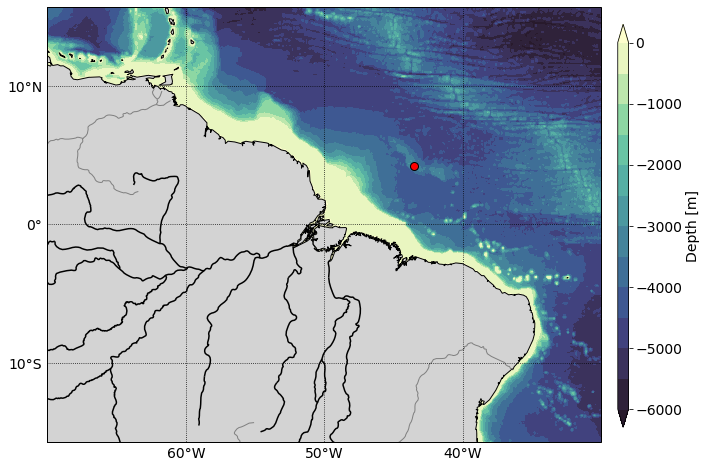

In [7]:
# Amazon catchment rivers
Rivers = [
    'Amazonas', 'Araguaia', 'Braco Menor', 'Branco', 'Caquetá', 'Culuene',
    'Guaporé', 'Japurá', 'Juruena', 'Madeira', 'Madre de Dios', 'Mamoré',
    'Marañón', 'Negro', 'Purús', 'Tapajós', 'Tocantins', 'Ucayali', 'Xingu',
]

# Define plotting boundaries
xbound, ybound = [-70, -30], [-15, 15] # Sets the projection extent
xlim, ylim = [-70, -20], [-20, 30]     # Sets the gridline and bathymetry extent

# Make projection and coastlines
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': crs.PlateCarree(np.mean(xbound))})
cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
ax.set_extent(xbound + ybound)
ax.add_feature(feature.GSHHSFeature('low', edgecolor='k', facecolor='lightgray'))

# Plot Amazon catchment rivers
# Code to add all rivers regardless of watershed (do this once to download shapefile)
#ax.add_feature(feature.NaturalEarthFeature(
#    category='physical', name='rivers_lake_centerlines', scale='50m', facecolor='none', edgecolor='k',
#)
# Code to plot Amazon rivers separately
fpath = os.path.join(config['data_dir'], 'shapefiles/natural_earth/physical/ne_50m_rivers_lake_centerlines.shp')
for rec in shapereader.Reader(fpath).records():
    lw, color = (1.5, 'k') if rec.attributes['name'] in Rivers else (1, 'gray')
    ax.add_geometries([rec.geometry], crs.PlateCarree(), edgecolor=color, linewidth=lw, facecolor='none')

# Add bathymetry (interpolate to 0.1 deg to reduce plotting resolution)
topo_amazon = topo.interp(x=np.arange(*xlim, 0.1), y=np.arange(*ylim, 0.1))
lon, lat, depth = [topo_amazon[var].values for var in ['x', 'y', 'z']]
c = ax.contourf(lon, lat, depth, levels=range(-6000, 1, 500), cmap=cm.deep_r, extend='both', transform=crs.PlateCarree())

# Plot core site
ax.plot(-43.4883, 4.203, 'ko', markerfacecolor='r', markersize=8, transform=crs.PlateCarree())

# Add gridlines, ticks and colorbar
xticks, yticks = [list(range(*l, 10)) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xticks, ylocs=yticks)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False
fig.colorbar(c, cax=cax, label='Depth [m]')

plt.show()
#fig.savefig('/home/bmoorema/Desktop/Amazon_map.pdf', bbox_inches='tight')